#### AWS

Include the analysis script and setup the folders with raw data

We used a 10G connection instance 

Zone: eu-west-1a, instance type p3.2xlarge = 

- 1	GPUs - Tesla V100
- N/A	GPU Peer to Peer
- 16	GPU Memory (GB)
- 8	vCPUs
- 61	Memory (GB)
- Up to 10 Gbps Network Bandwidth	
- 1.5 Gbps EBS Bandwidth


boto3 endpoint = http://s3.amazonaws.com

In [1]:
from benchmarking.analysis.analyze_results import *

In [2]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking-raw/referenced-experiments/aws")
s3_folder_filter="aws_long_1/*benchmark_e2e*"

#### Load raw data

In [3]:
df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [00:12<00:00, 171.97it/s]


In [4]:
# Show data (to check if loaded correctly)

# df_dataloader_s3.sort_values(["start_time_x"], ascending=False)
# df_dataloader_scratch.sort_values(["start_time_x"], ascending=False)

In [5]:
# extract unique functions (for s3 and scratch, it's the same)
unique_functions_s3 = np.unique(df_dataloader_s3["item_x"])

# define colors for timelane items 
colors = {}
for i, color in zip(unique_functions_s3, ["red", "gold", "blue", "magenta", "aqua"]):
    colors[str(i)] = color
    
# define lanes (each lane is for a single function call (i.e. usage))
lanes={}
for i, lane in zip(unique_functions_s3, range(len(unique_functions_s3))):
    lanes[str(i)] = lane

# print to verify
print(f"Unique functions: {unique_functions_s3}")
print(f"Lanes: {lanes}")
    
# get the names of the runs for the iterators later on 
unique_runs_s3 = np.unique(df_dataloader_s3["run"])


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']
Lanes: {'batch': 0, 'next_data': 1, 'run_training_batch': 2, 'training_batch_to_device': 3}


#### Timeline plots

Each line corresponds to a unique function call.

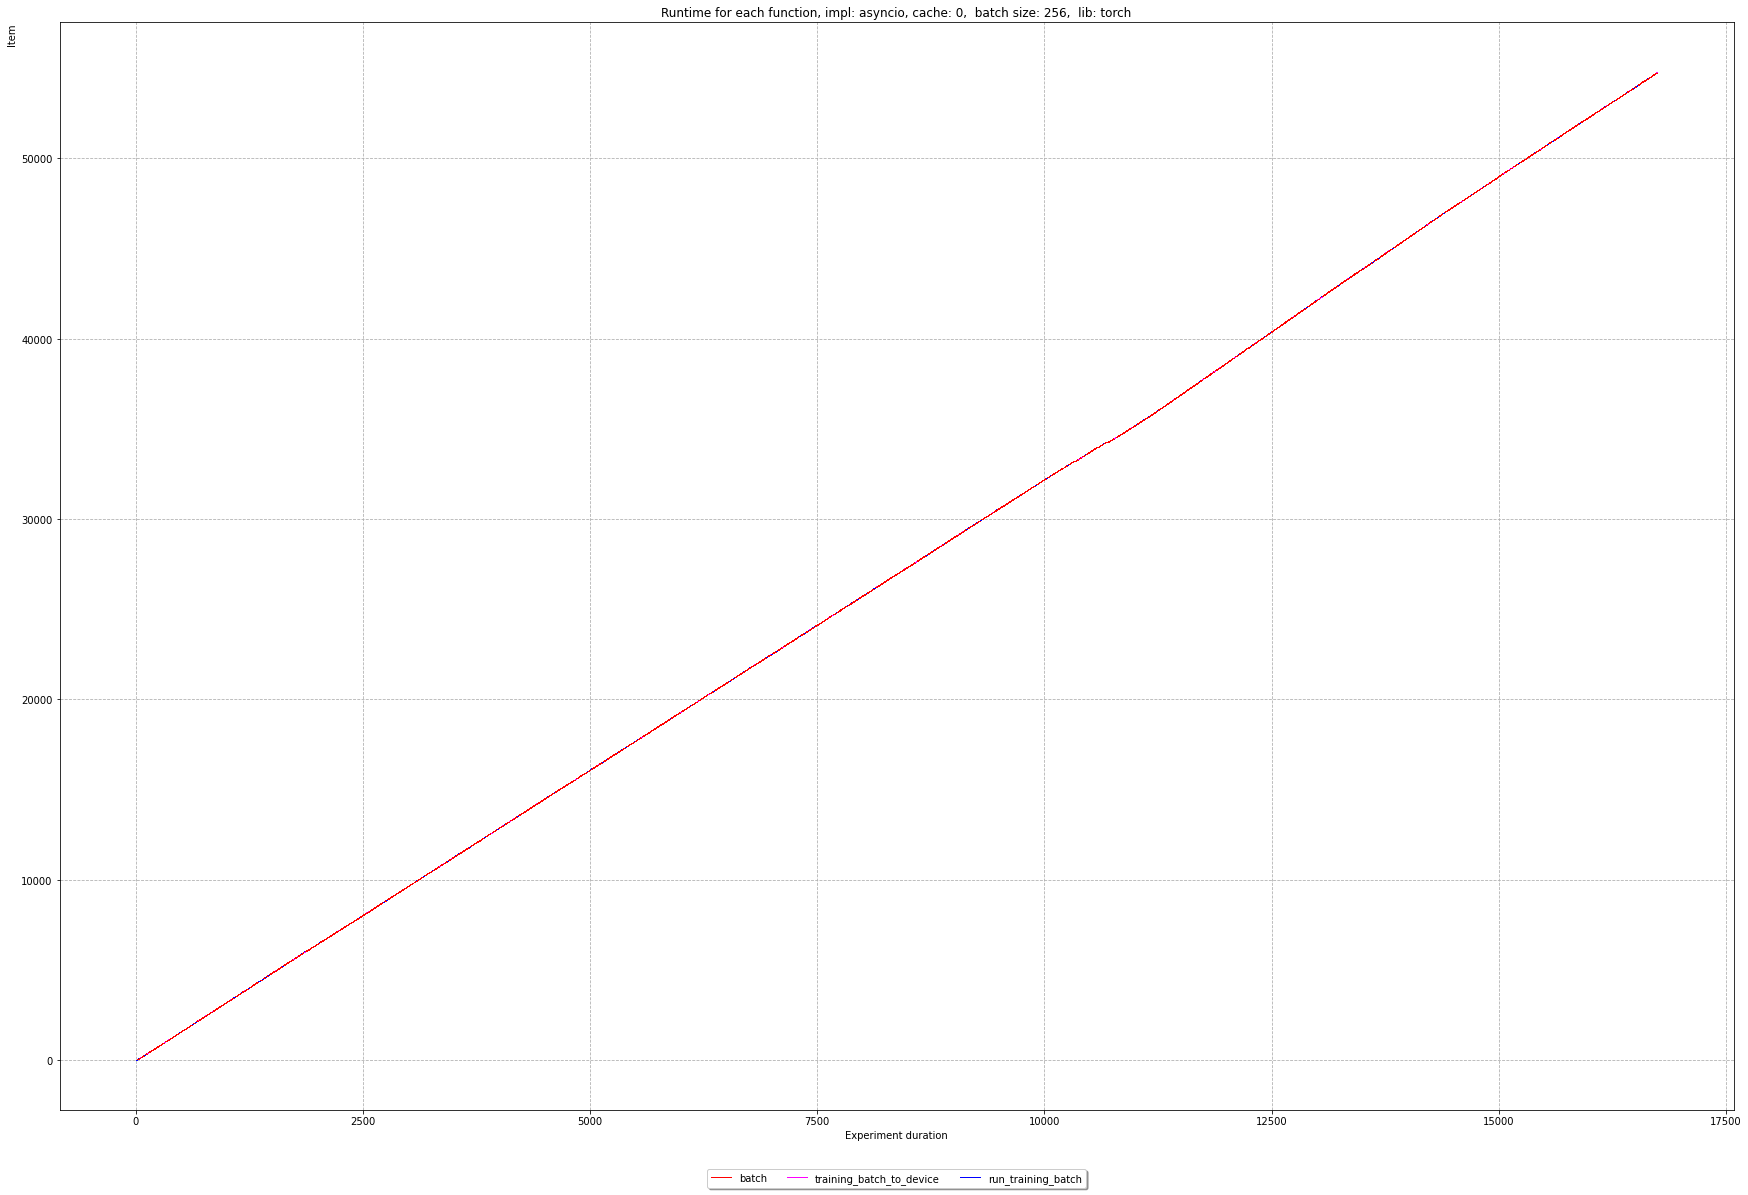

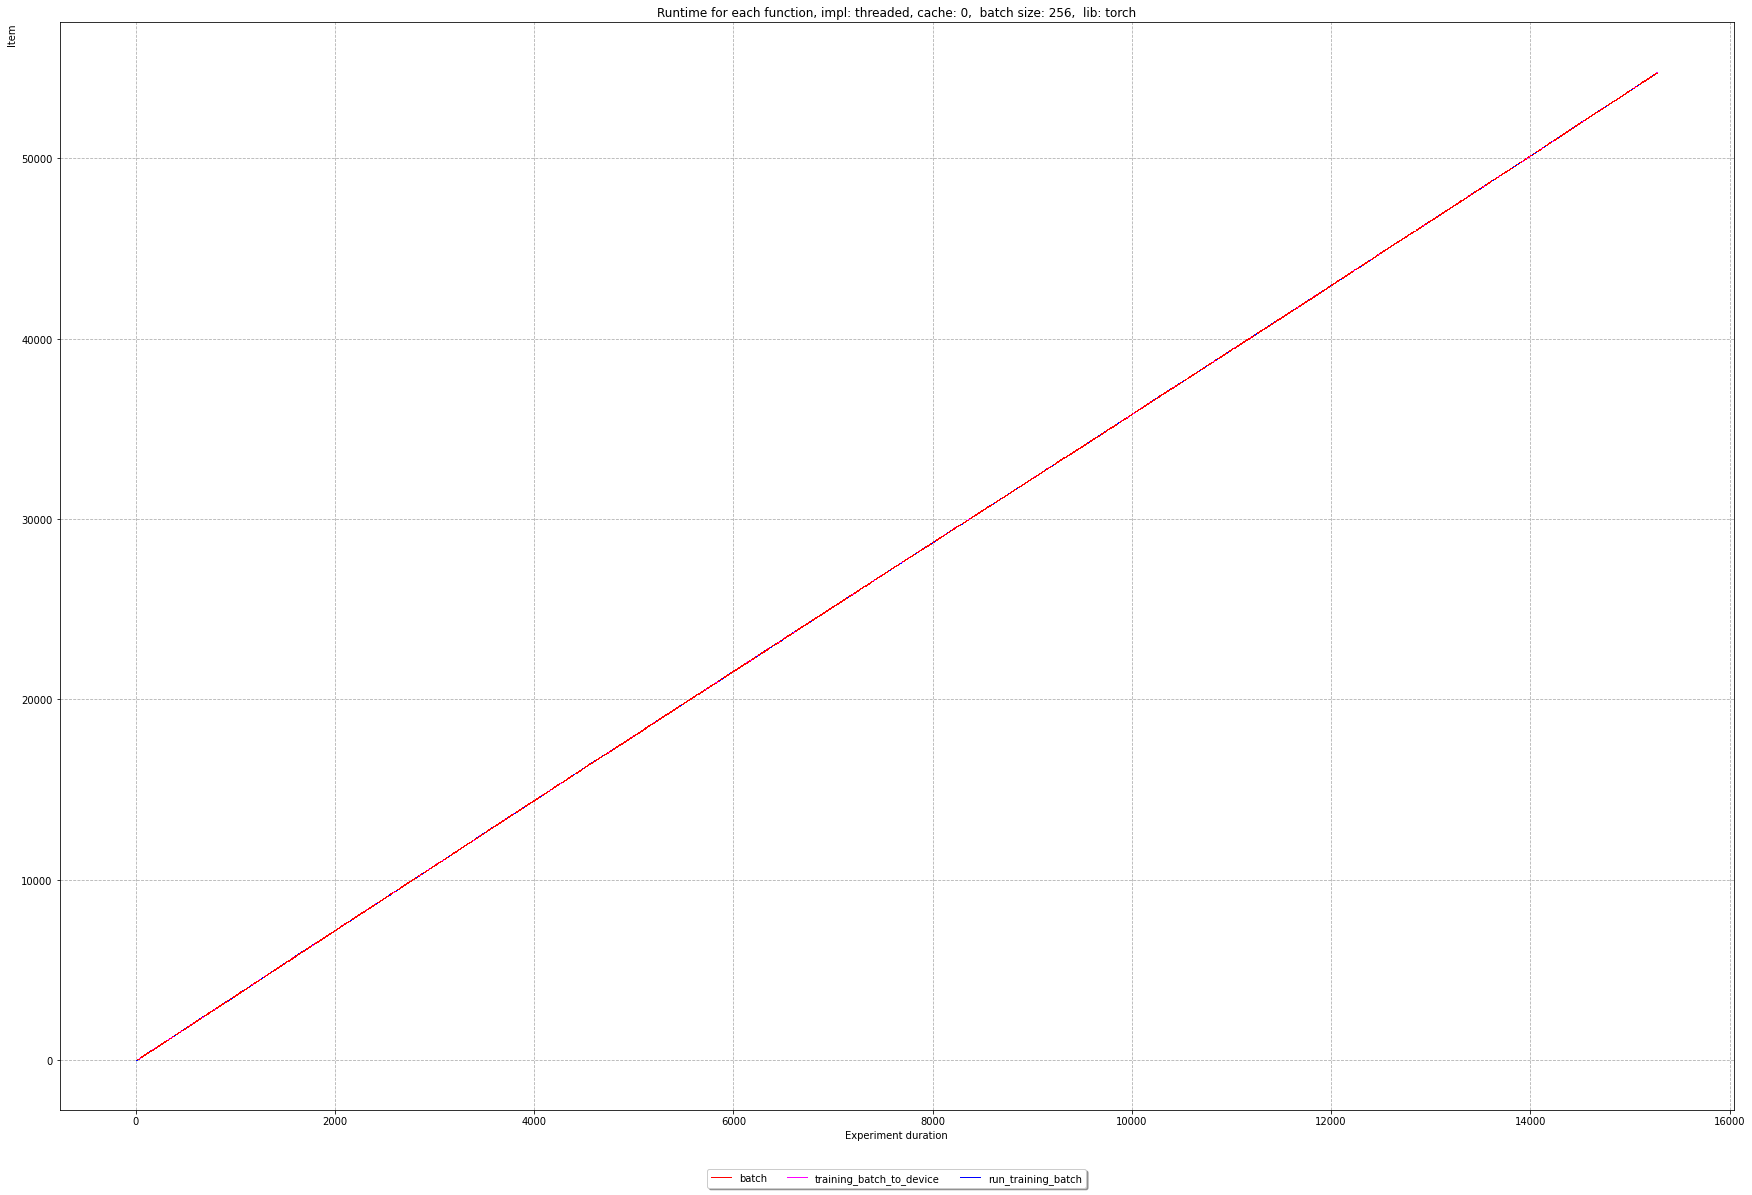

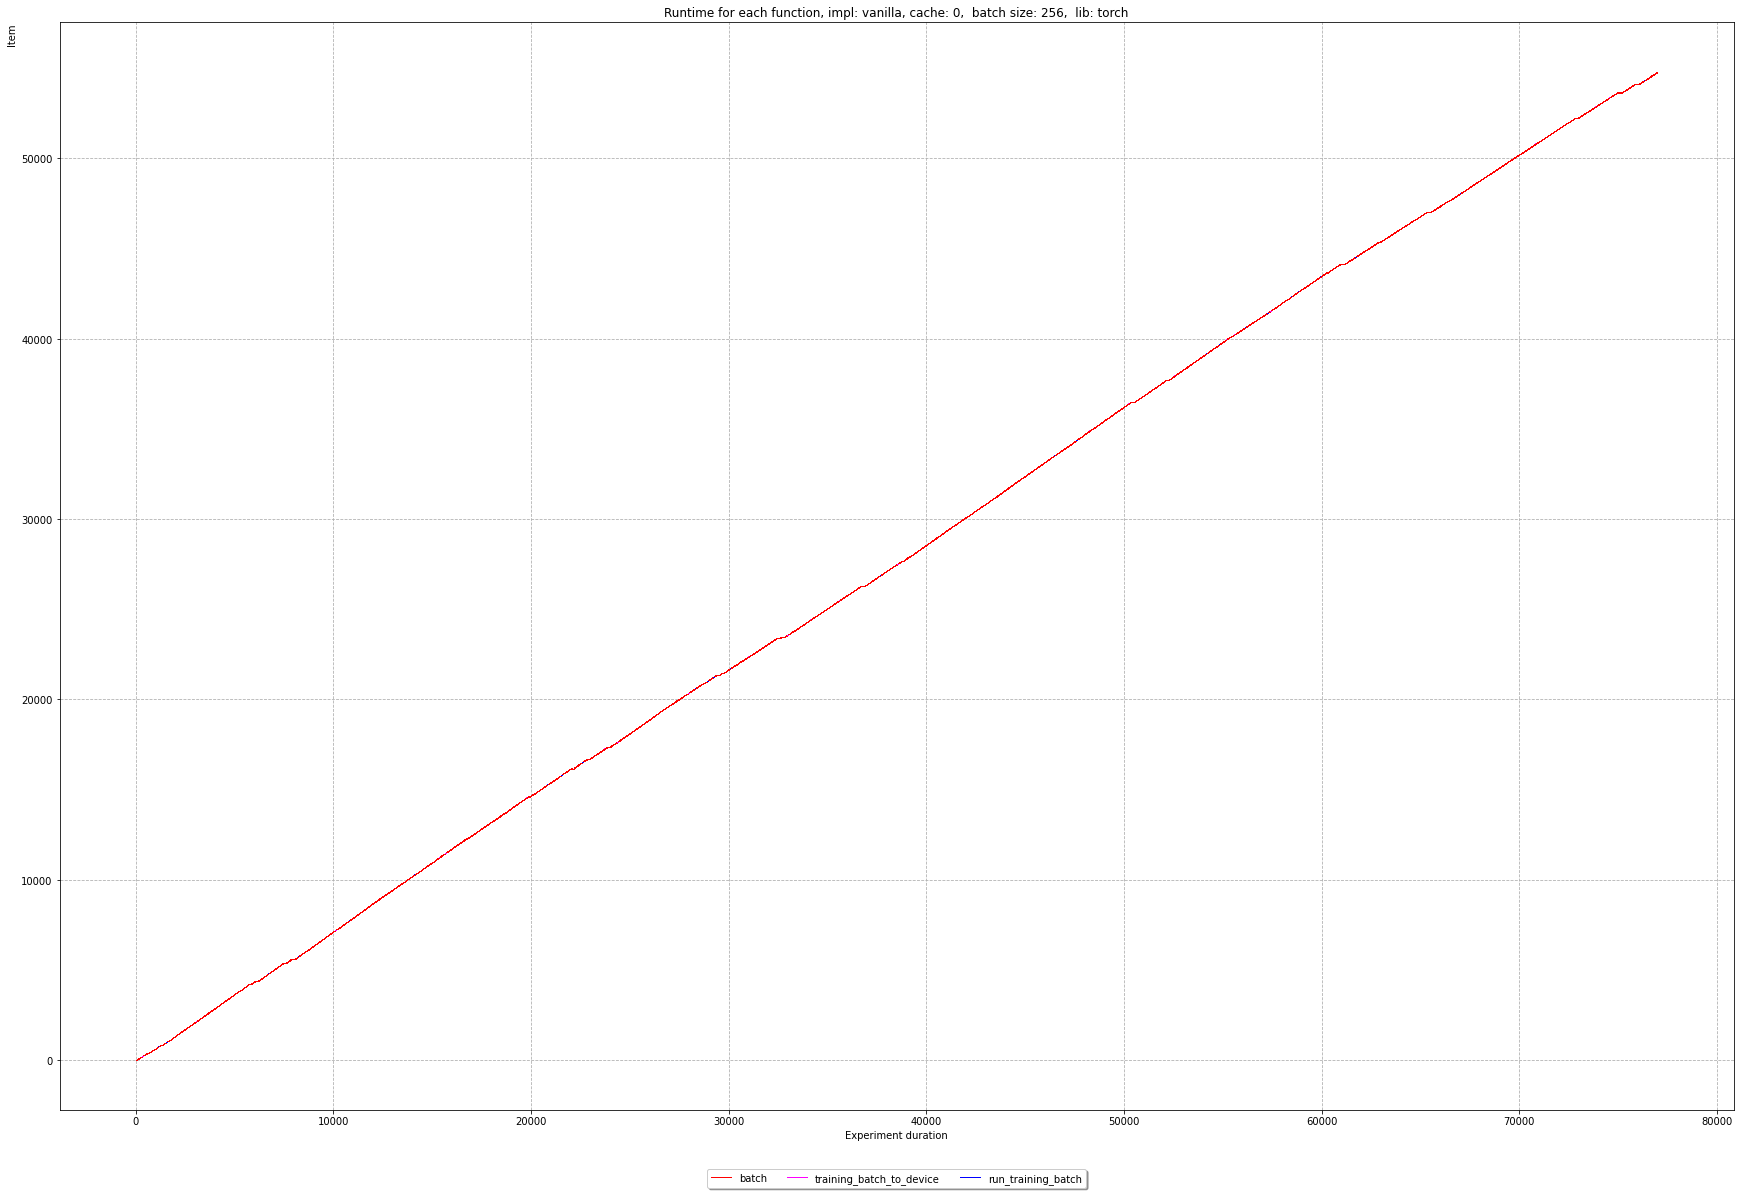

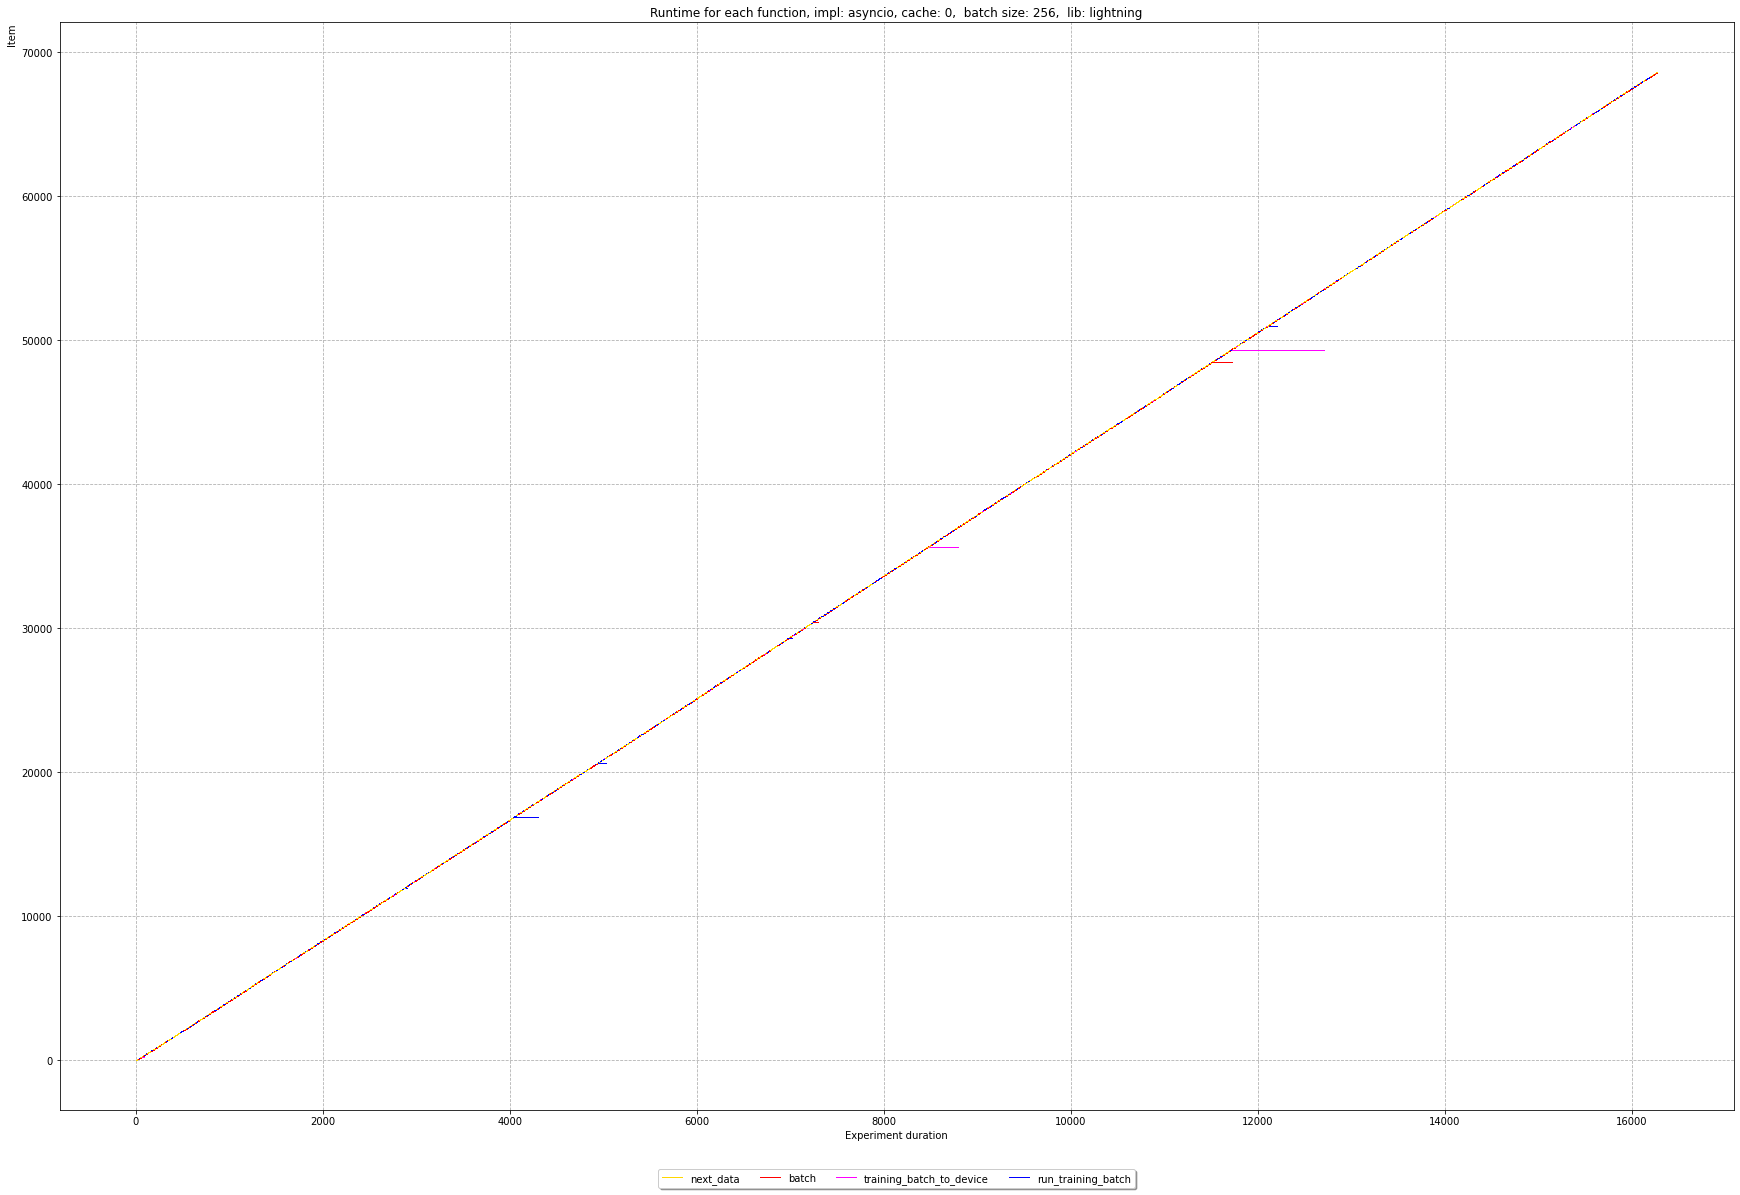

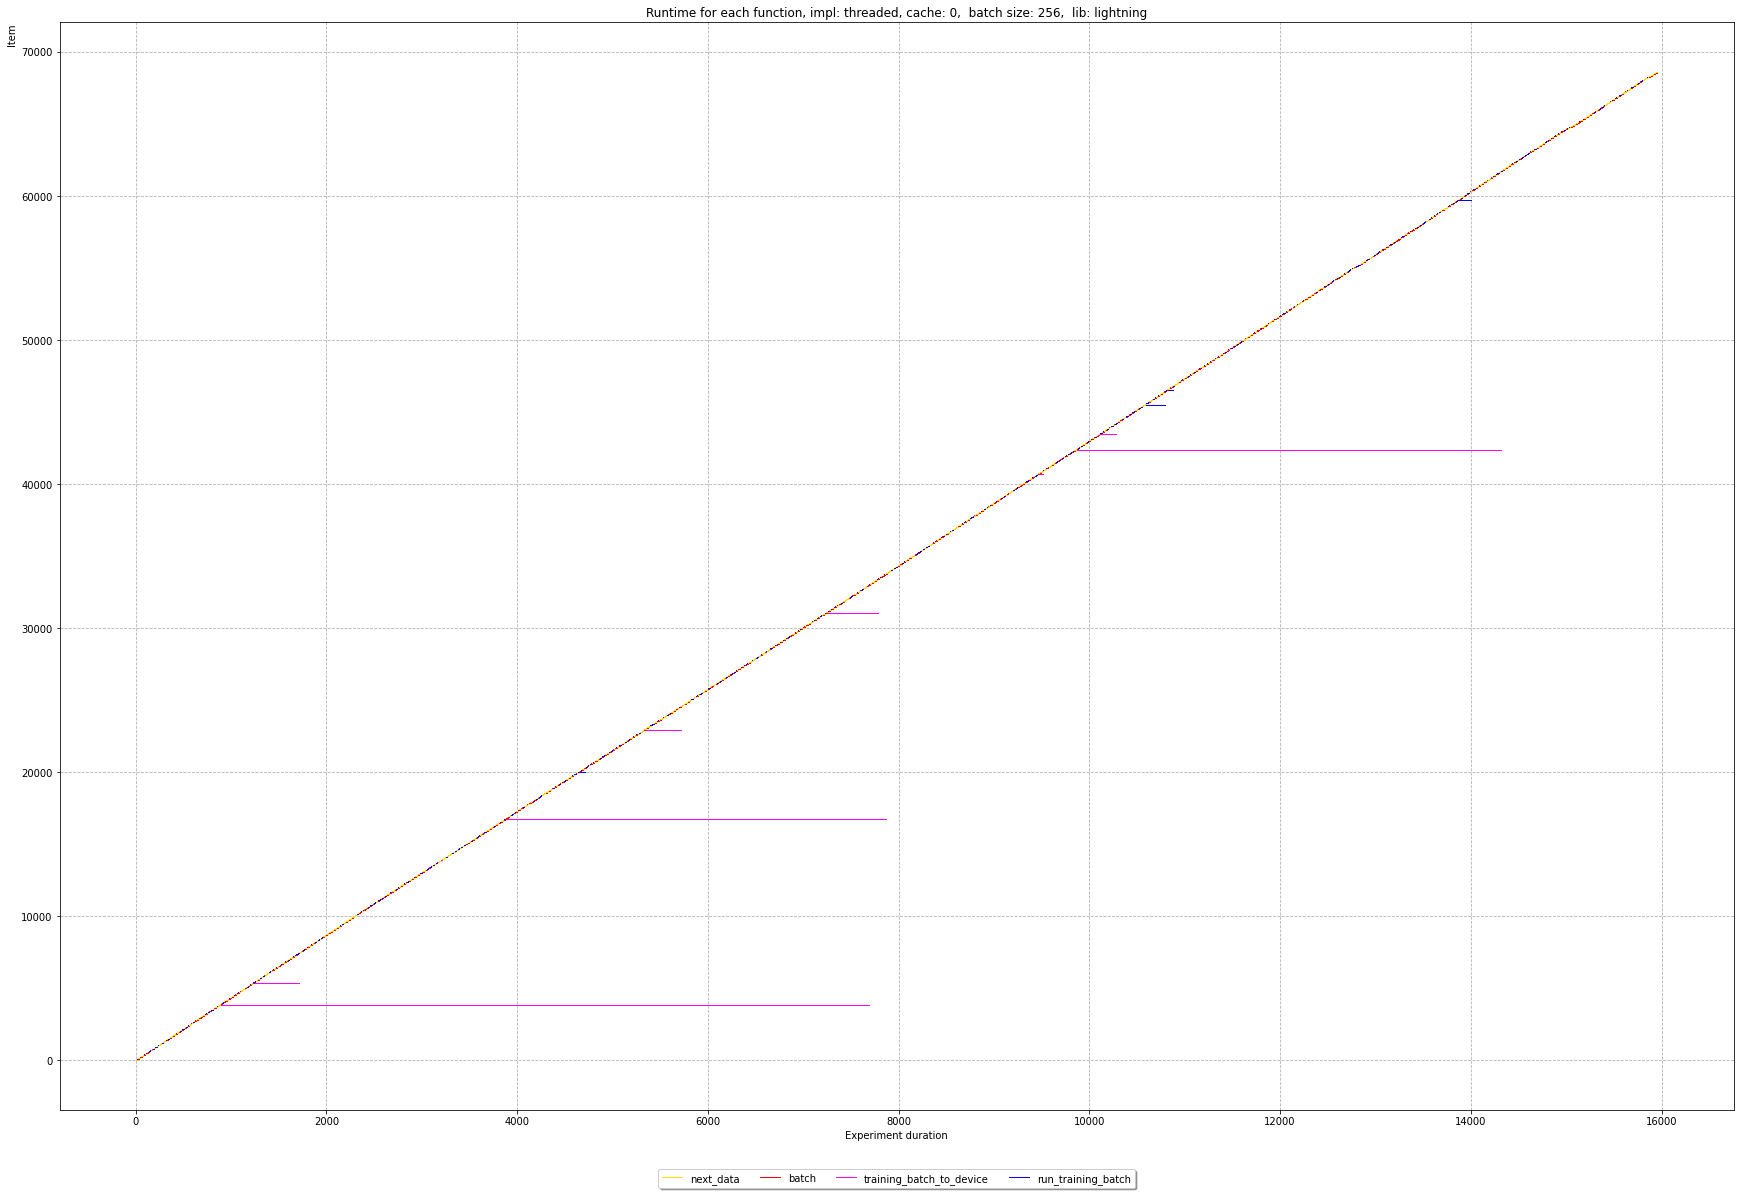

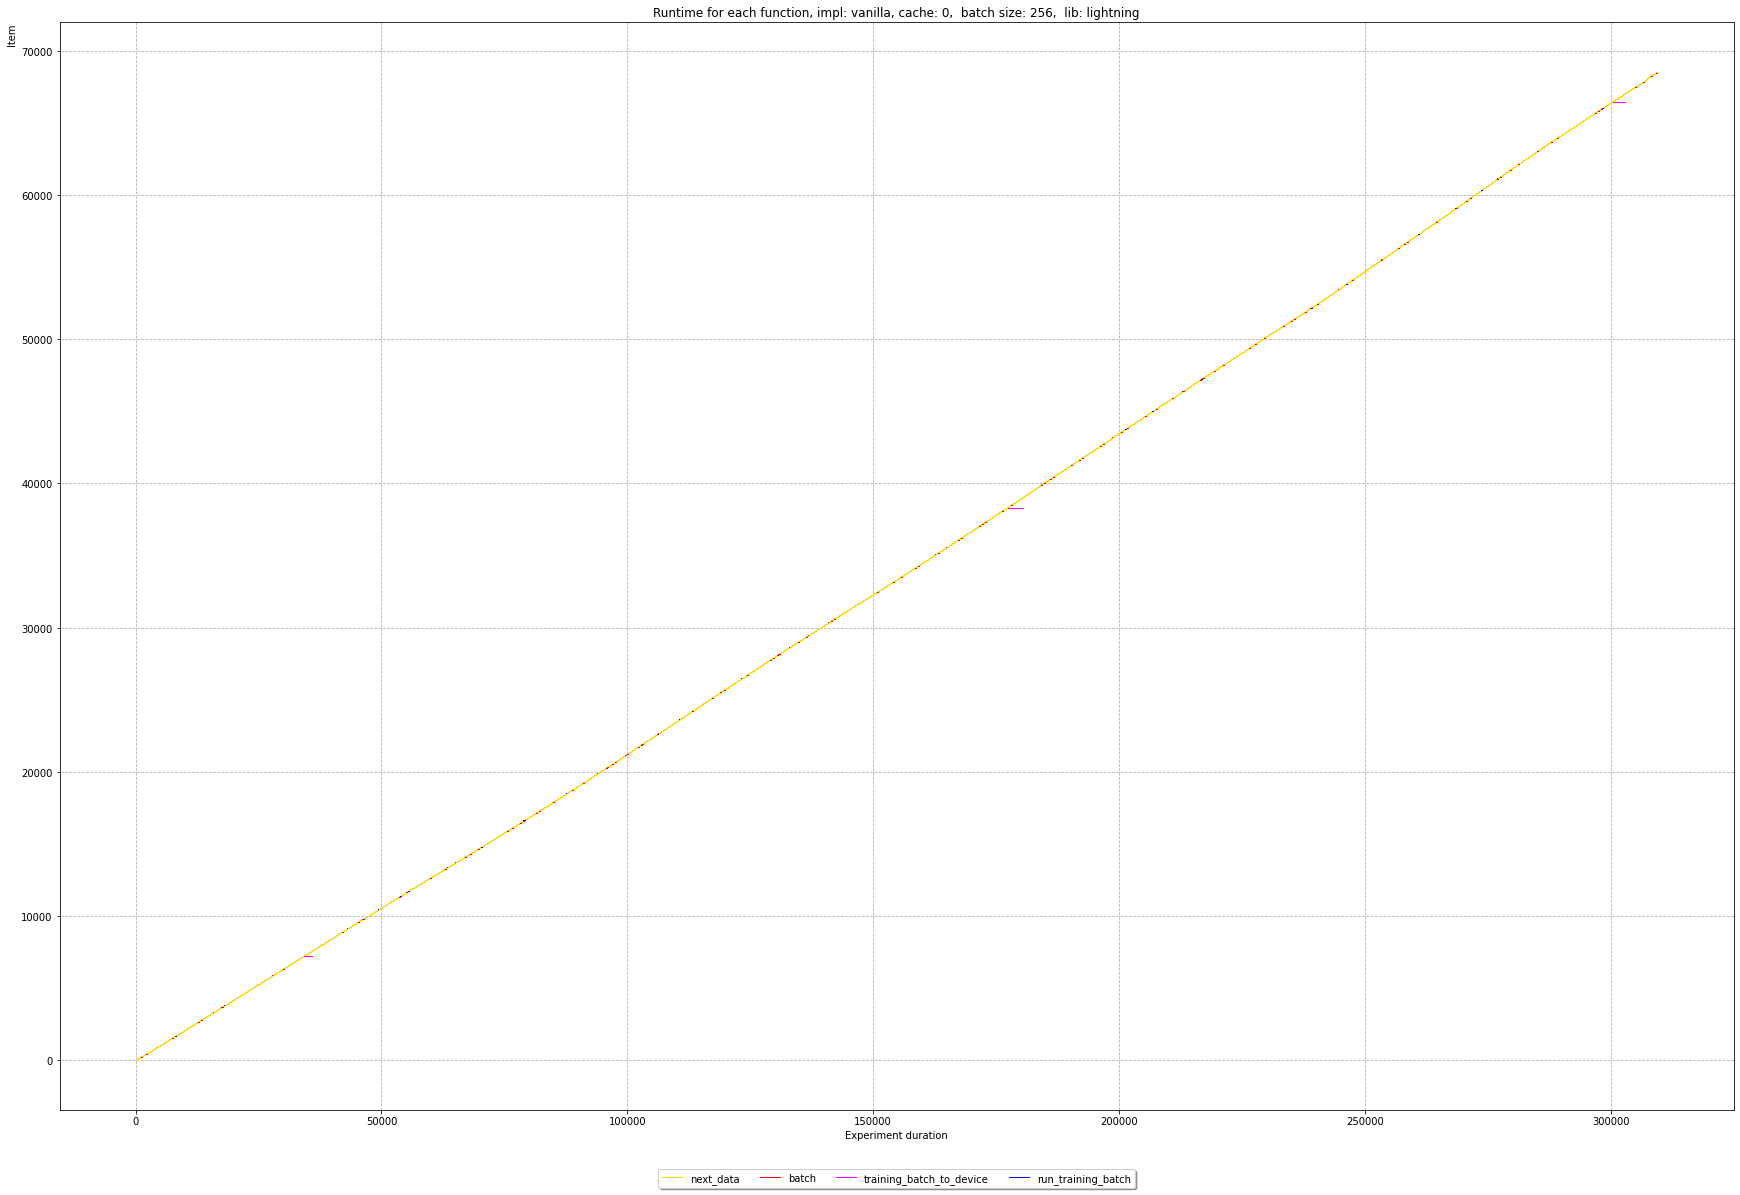

In [6]:
for implementation in ["torch", "lightning"]:
    for run in unique_runs_s3:
        if implementation in run:
            df = df_dataloader_s3[(df_dataloader_s3["run"]==run)]
            show_timelines(df, run, lanes, colors, False, False, 0.1)

### GPU Utilization

In [7]:
# Load the GPU utilization 
df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [00:14<00:00, 147.87it/s]


In [8]:
unique_runs_s3 = np.unique(df_dataloader_s3["run"])
print(unique_runs_s3)

['20220118f224612_benchmark_e2e_torch_s3_256_4_16_0_asyncio_sync'
 '20220119f032522_benchmark_e2e_lightning_s3_256_4_16_0_asyncio_sync'
 '20220119f075644_benchmark_e2e_torch_s3_256_4_16_0_threaded_sync'
 '20220119f121123_benchmark_e2e_lightning_s3_256_4_16_0_threaded_sync'
 '20220119f163729_benchmark_e2e_torch_s3_256_4_16_0_vanilla_sync'
 '20220121f082622_benchmark_e2e_lightning_s3_256_4_16_0_vanilla_sync']


73.0 46.333333333333336


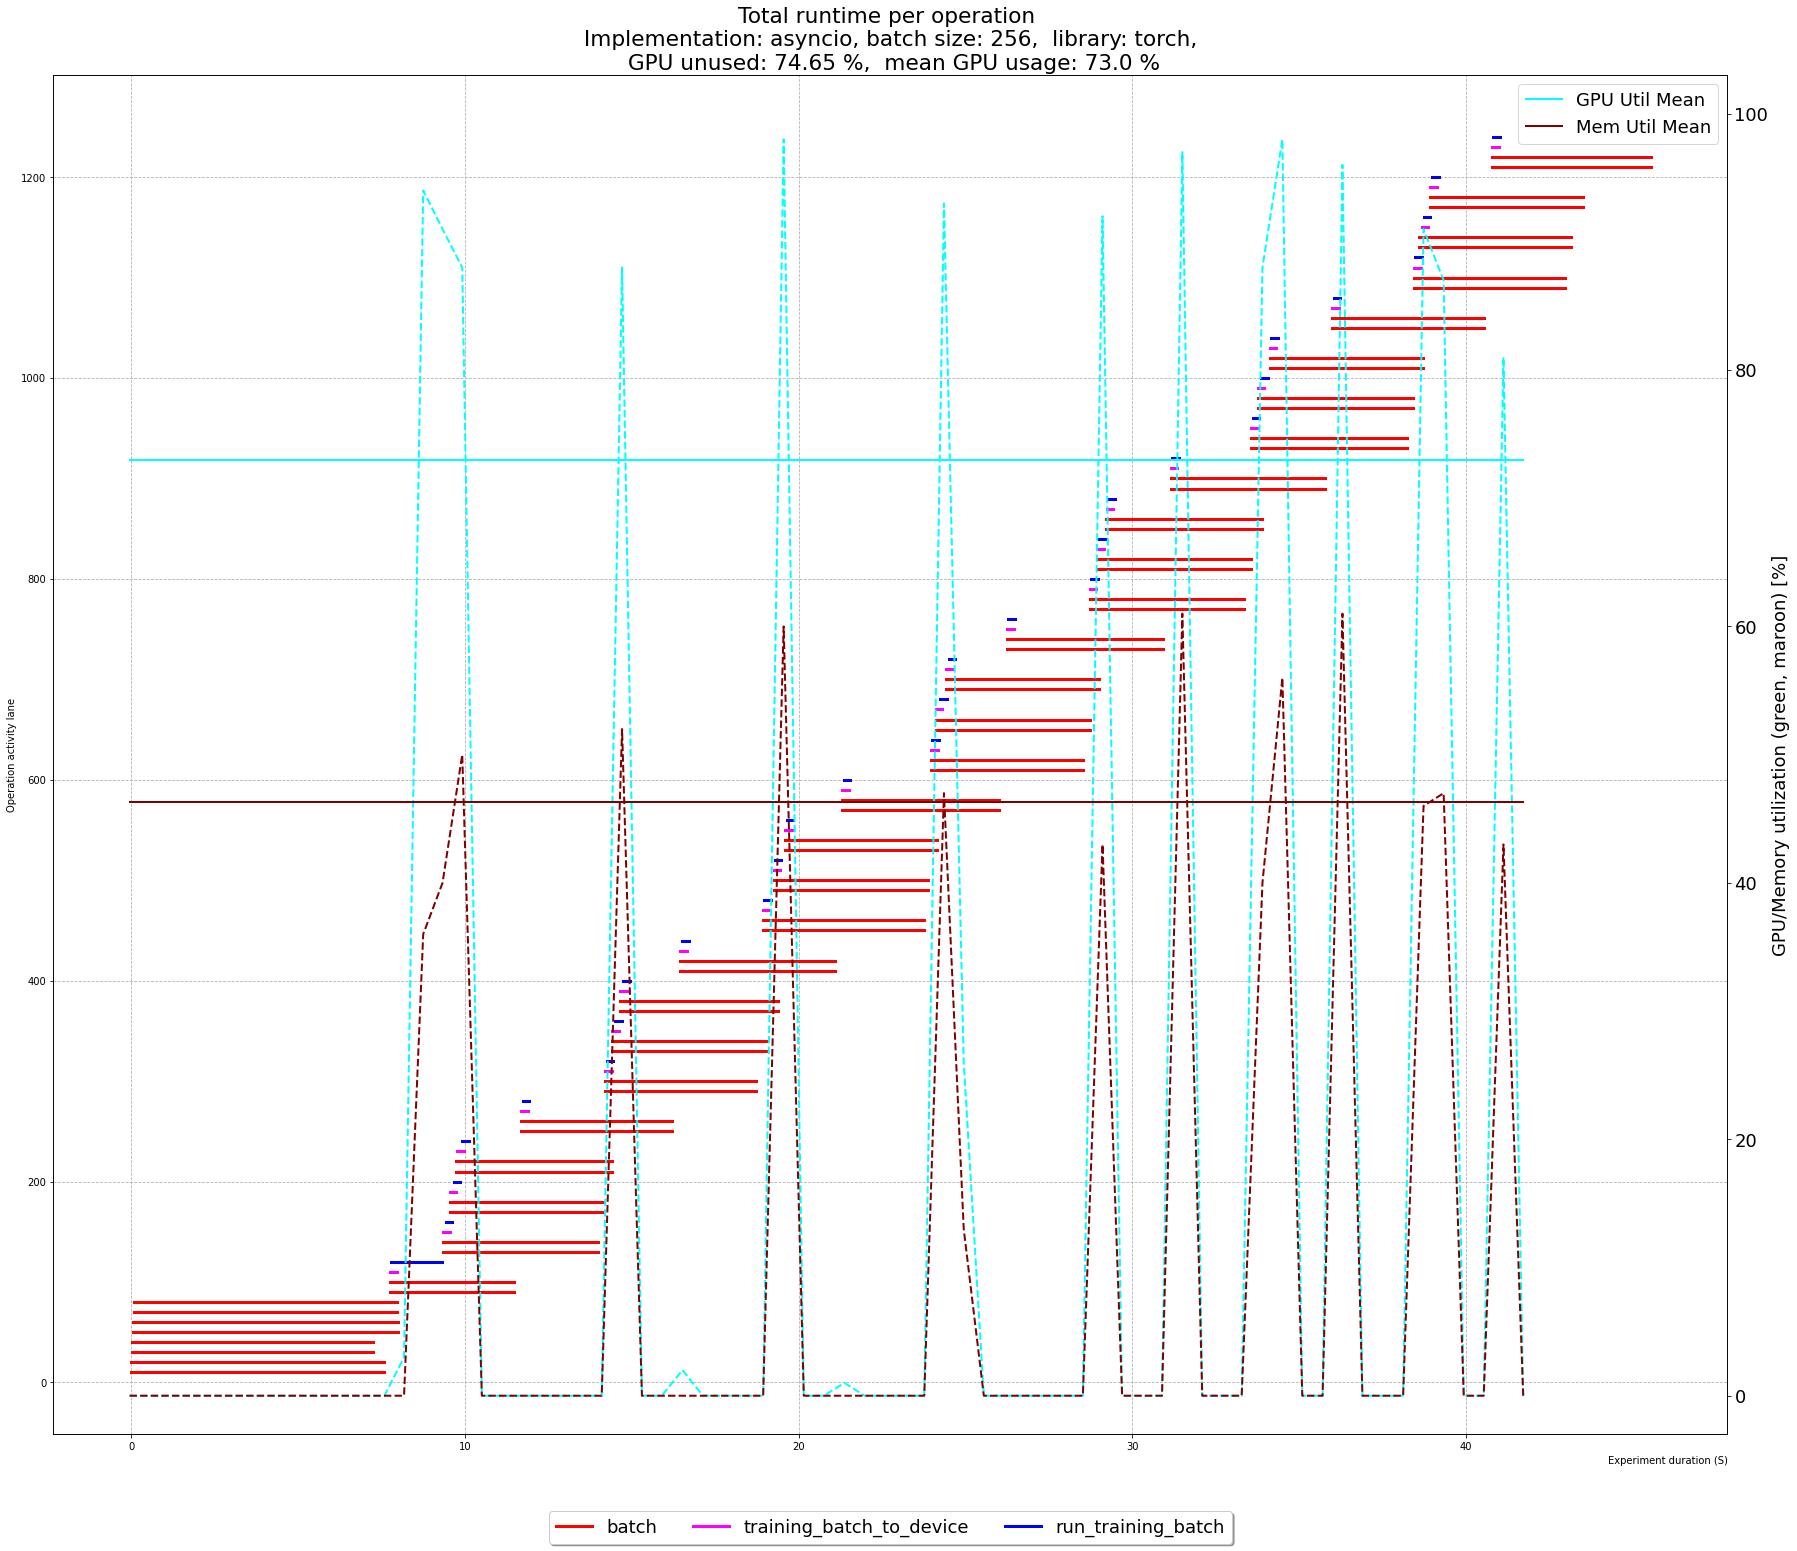

41.125 20.9375


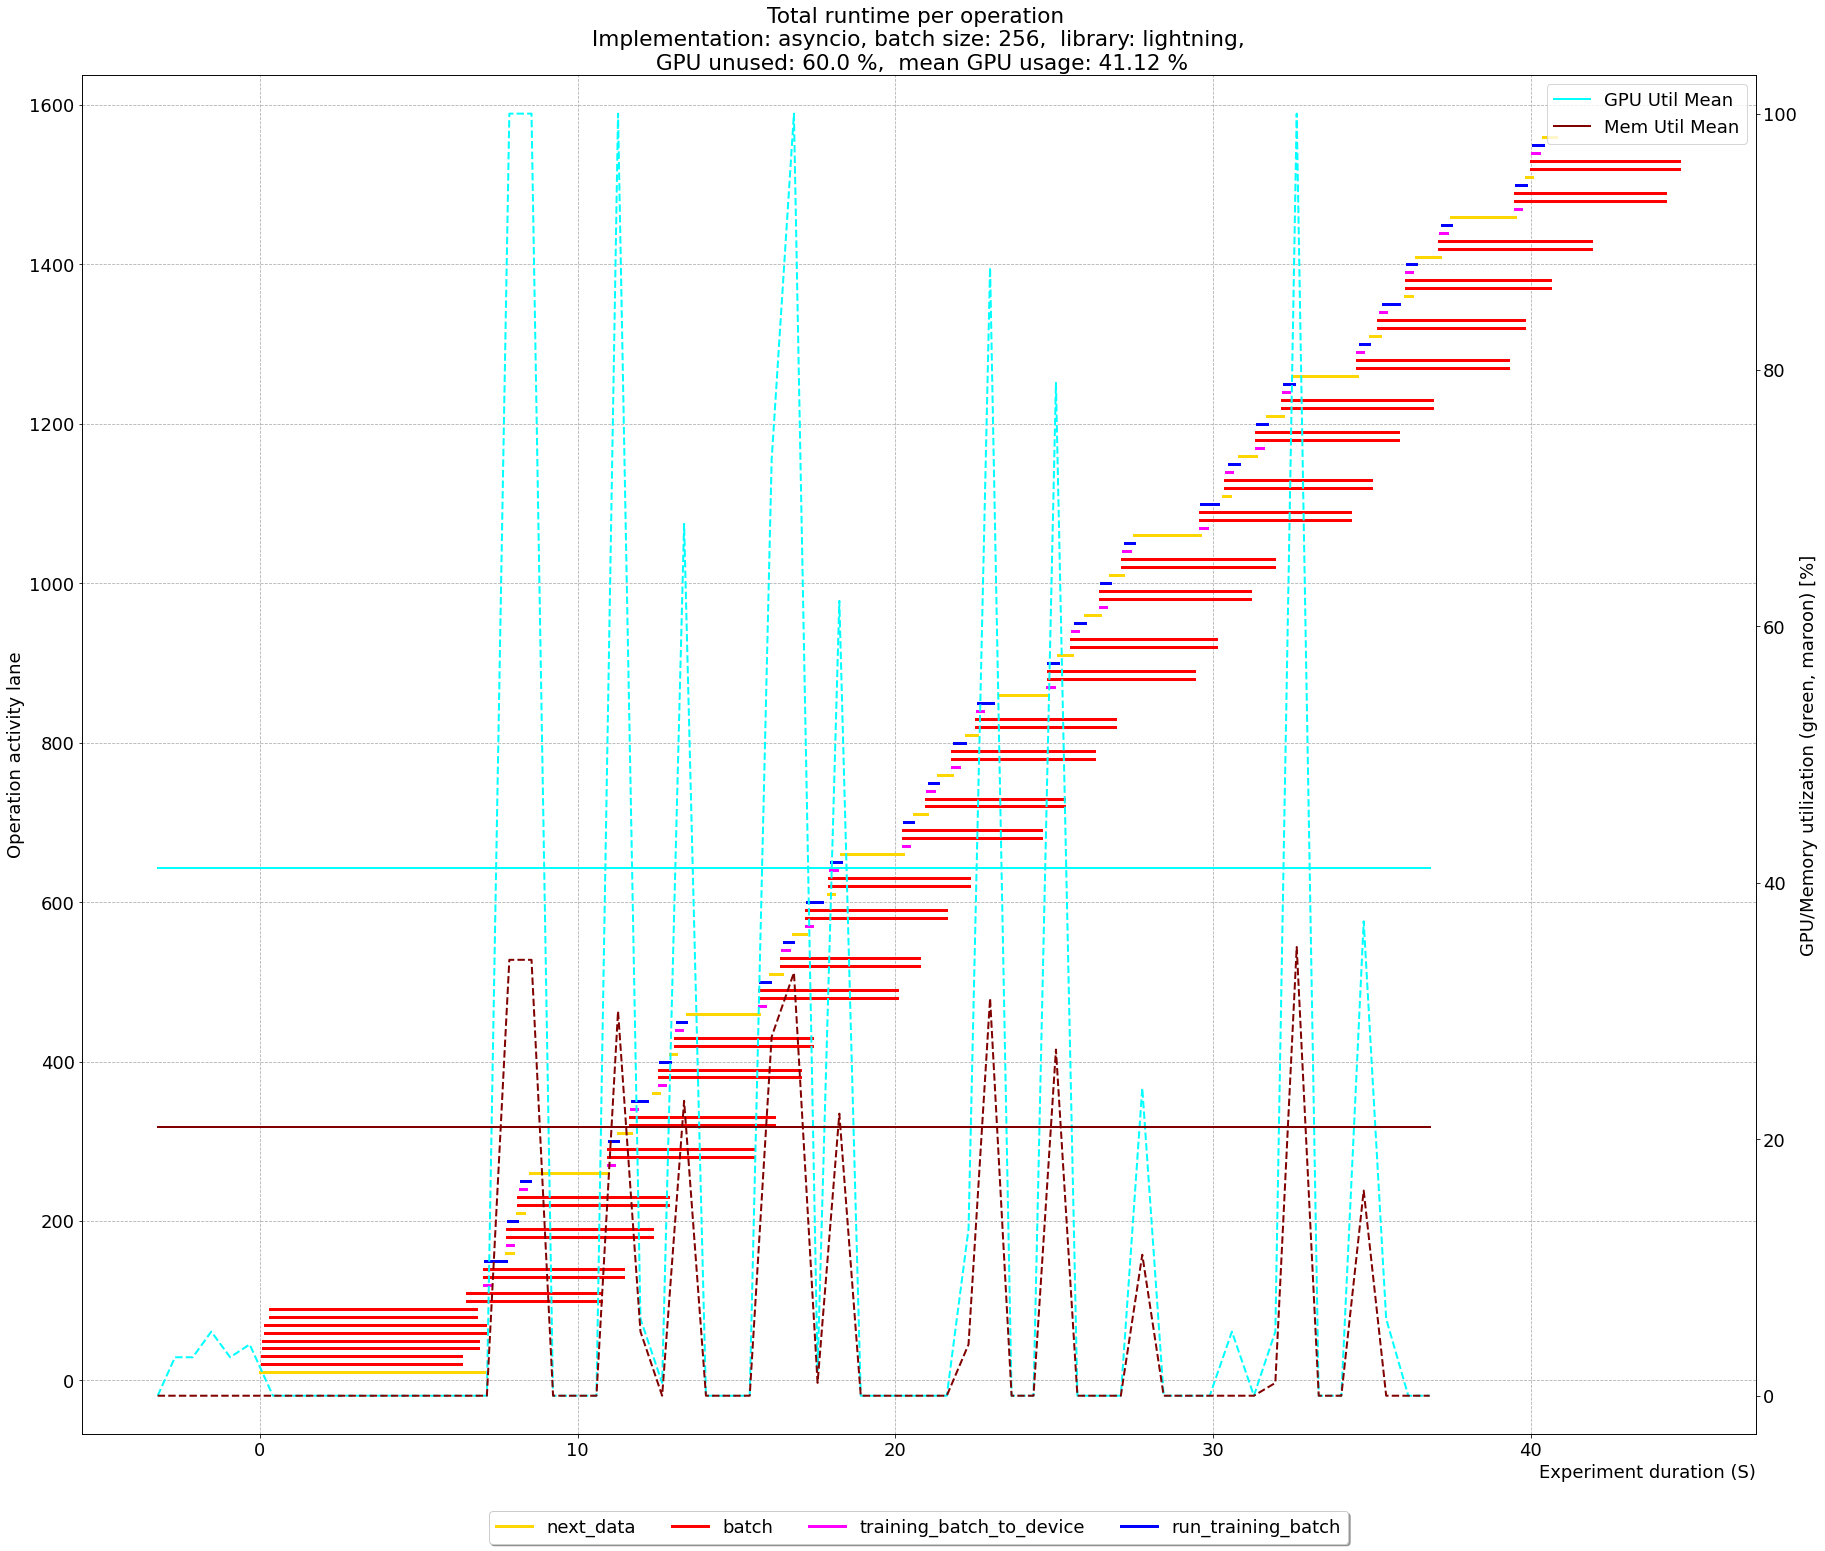

49.53333333333333 31.166666666666668


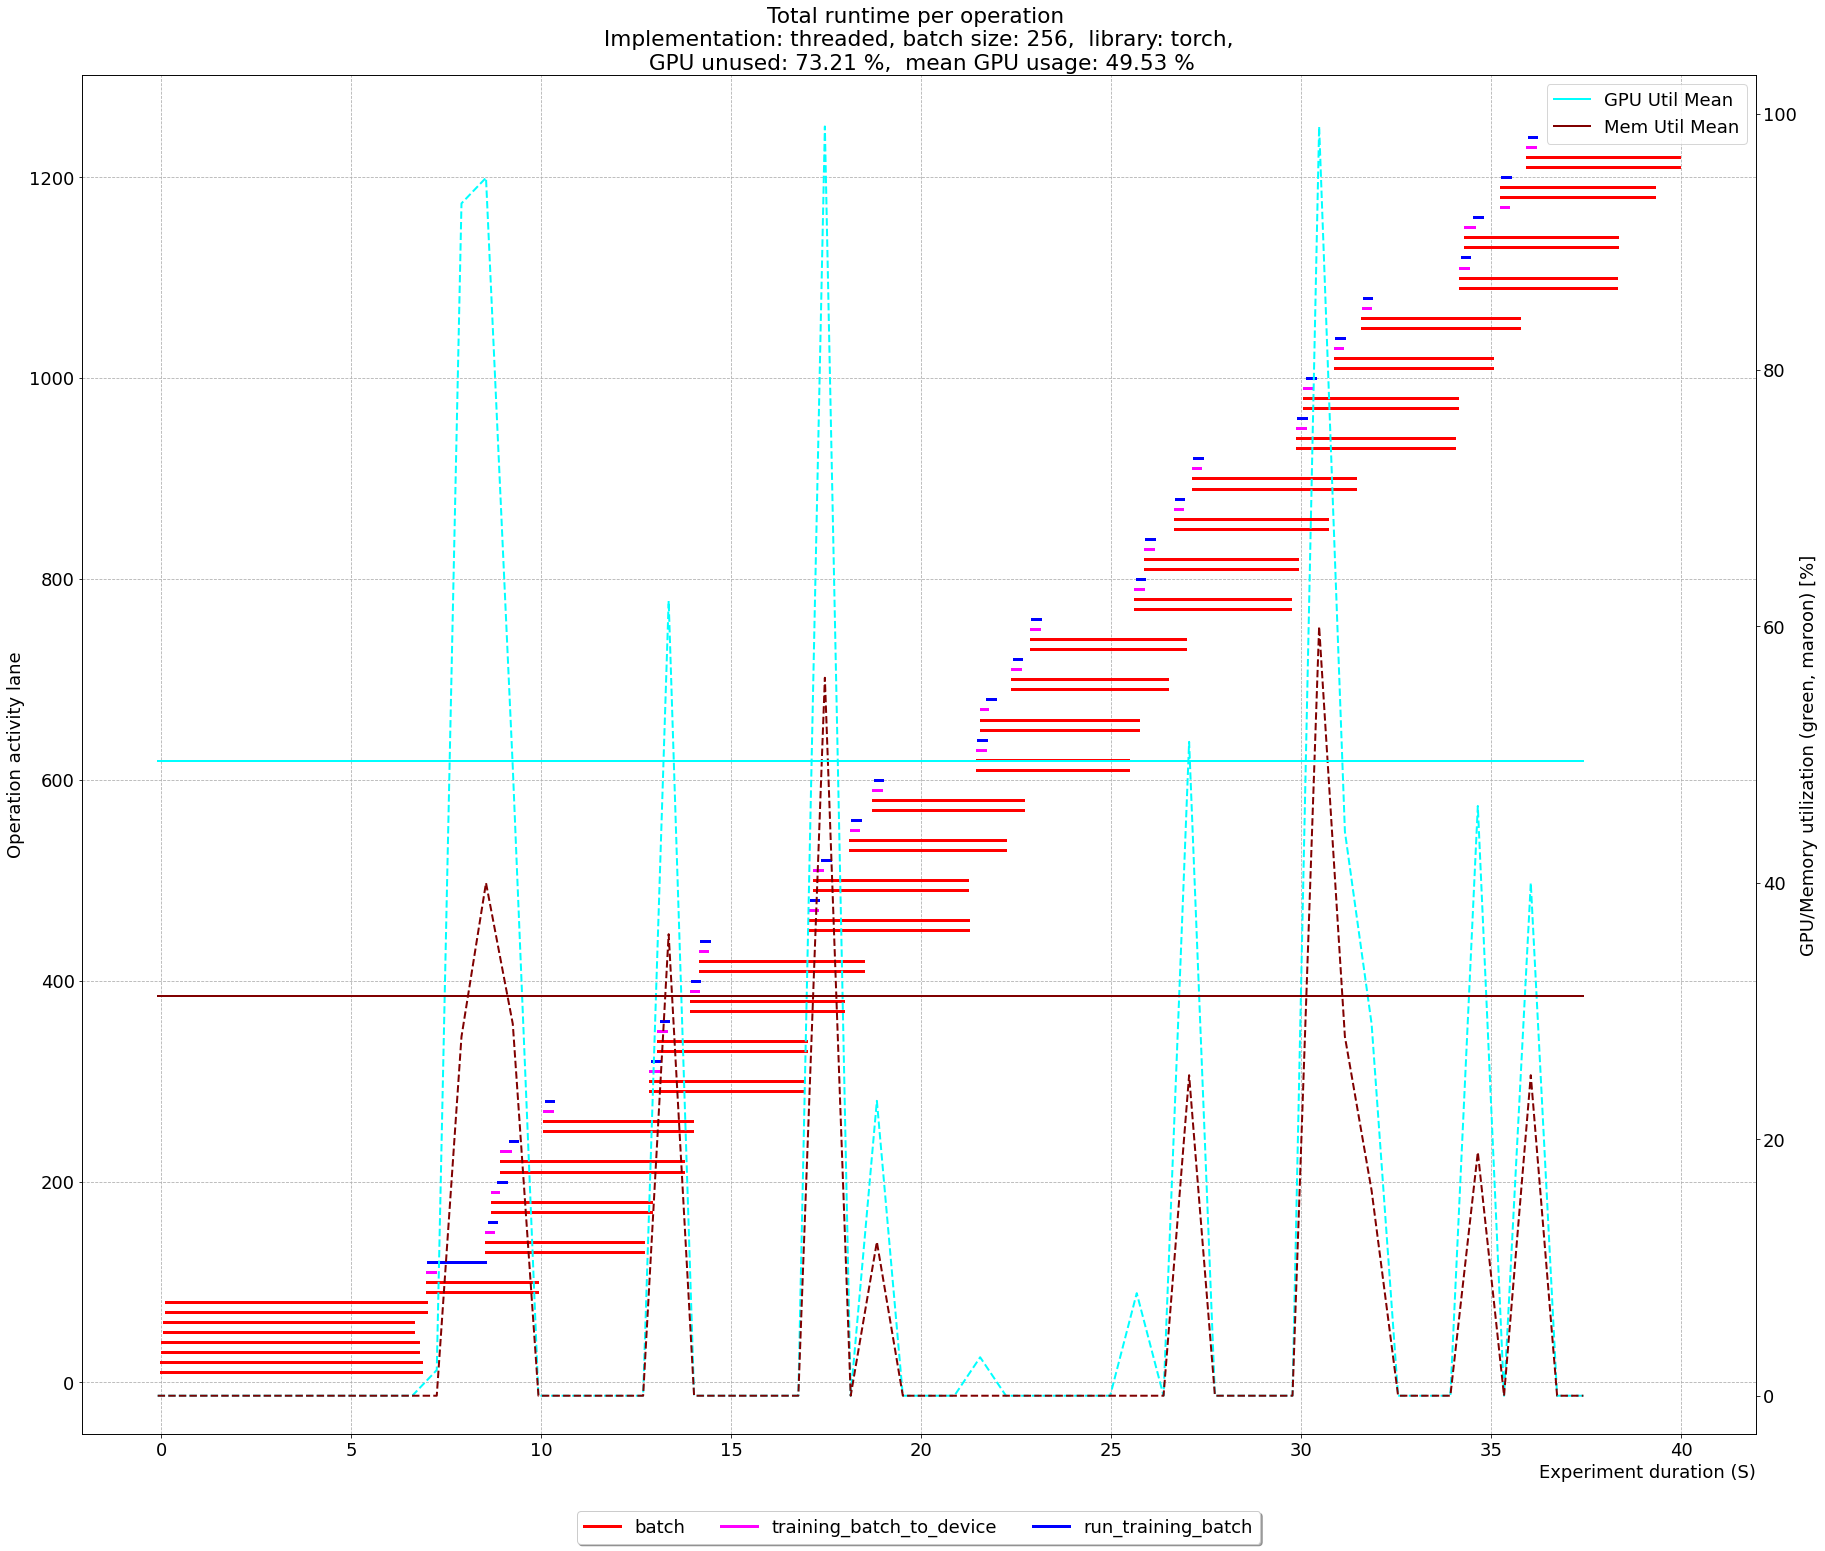

52.84 26.176470588235293


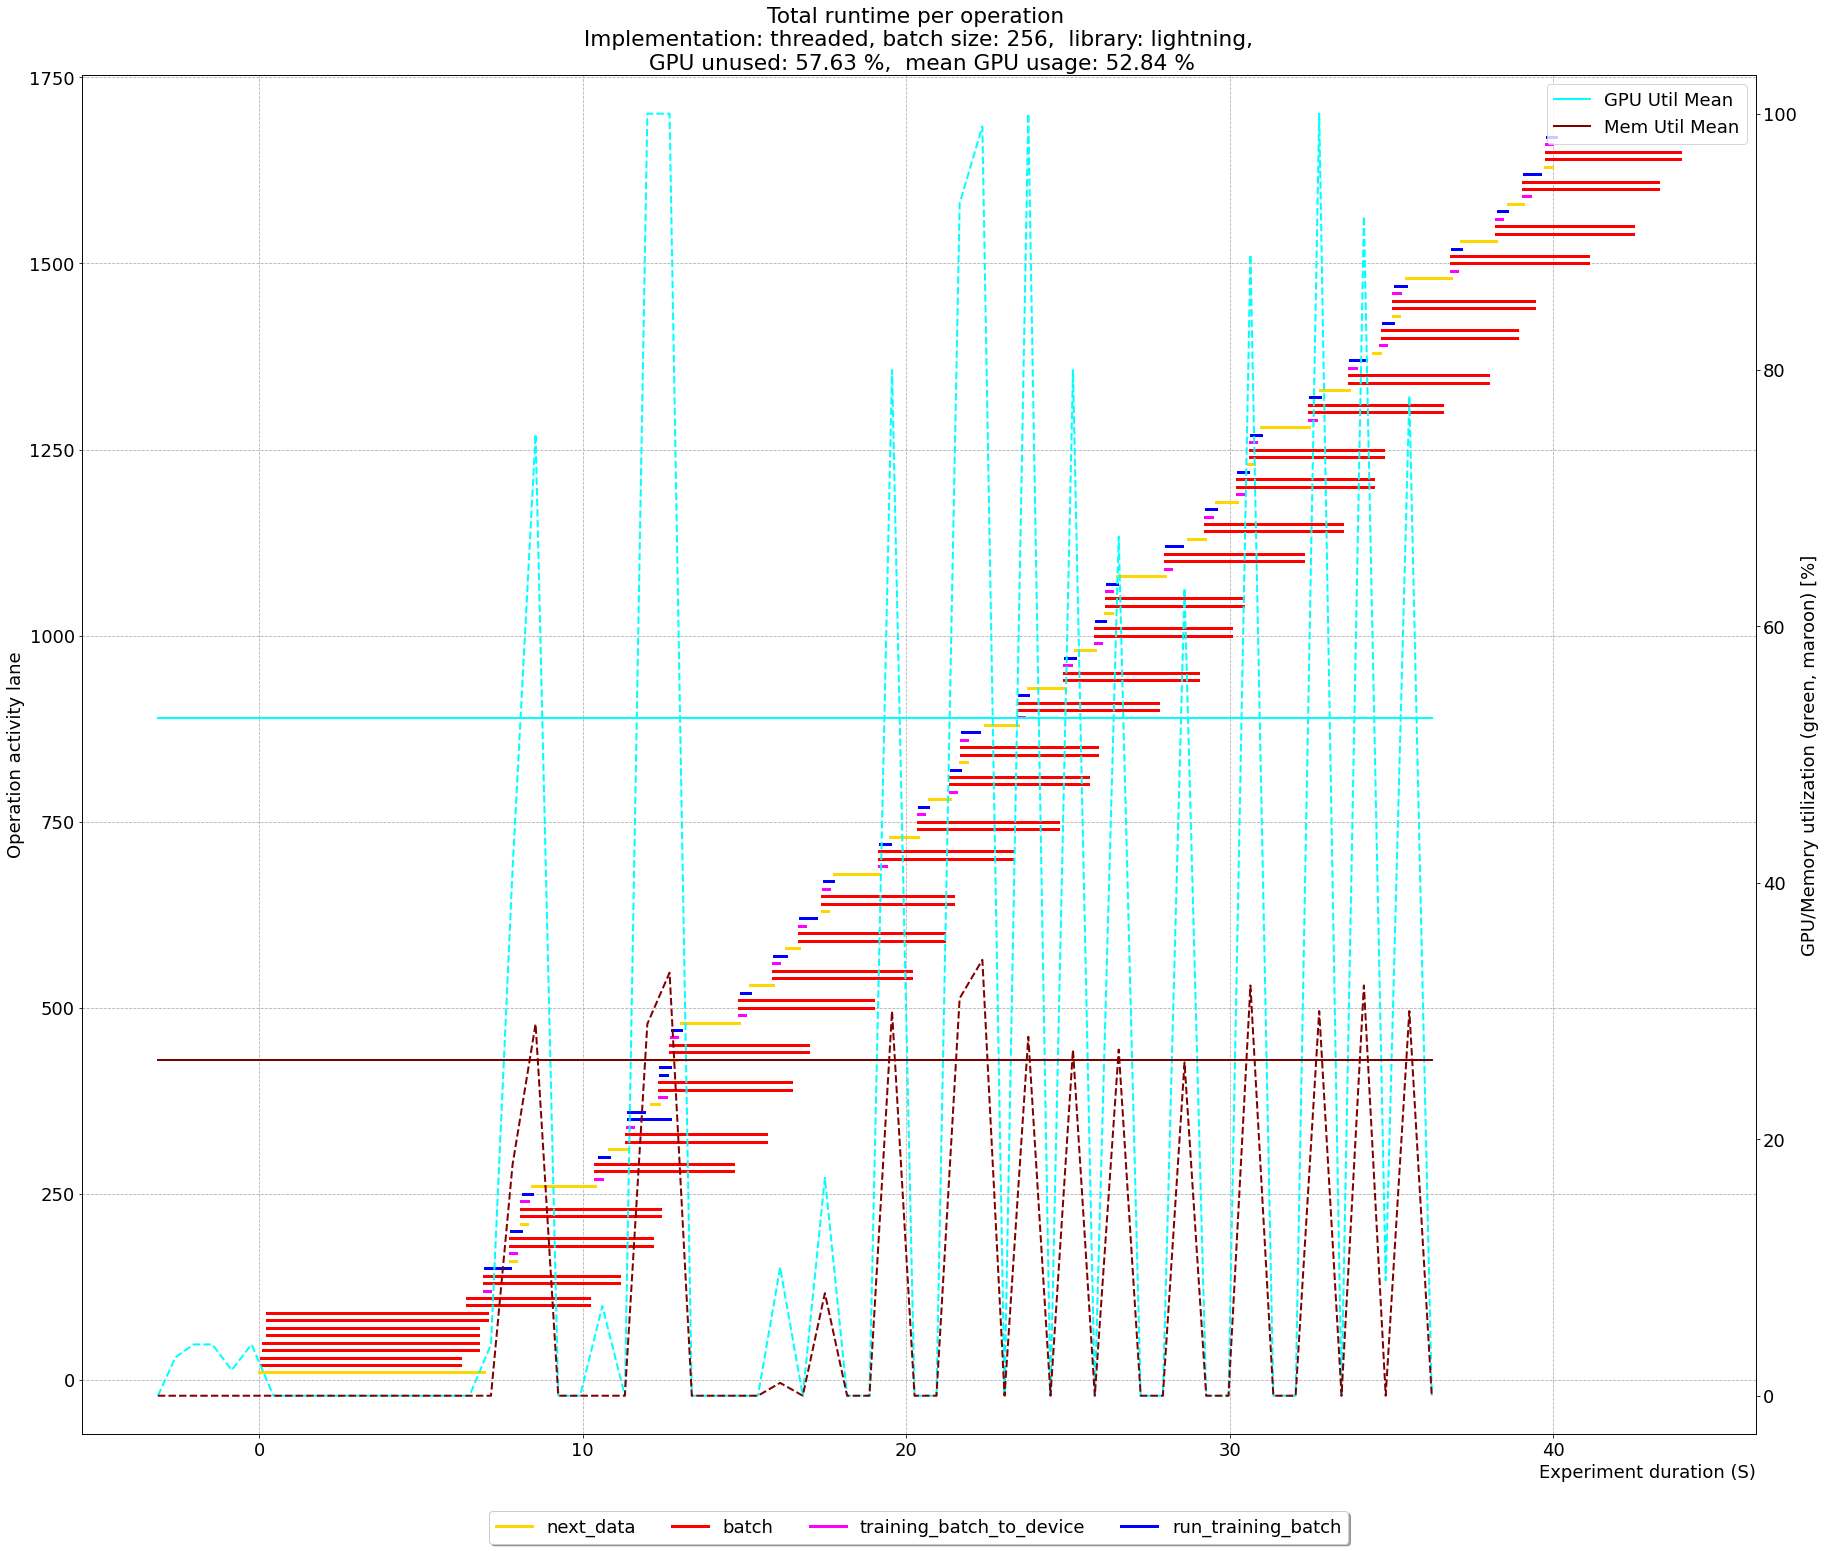

59.904761904761905 37.94444444444444


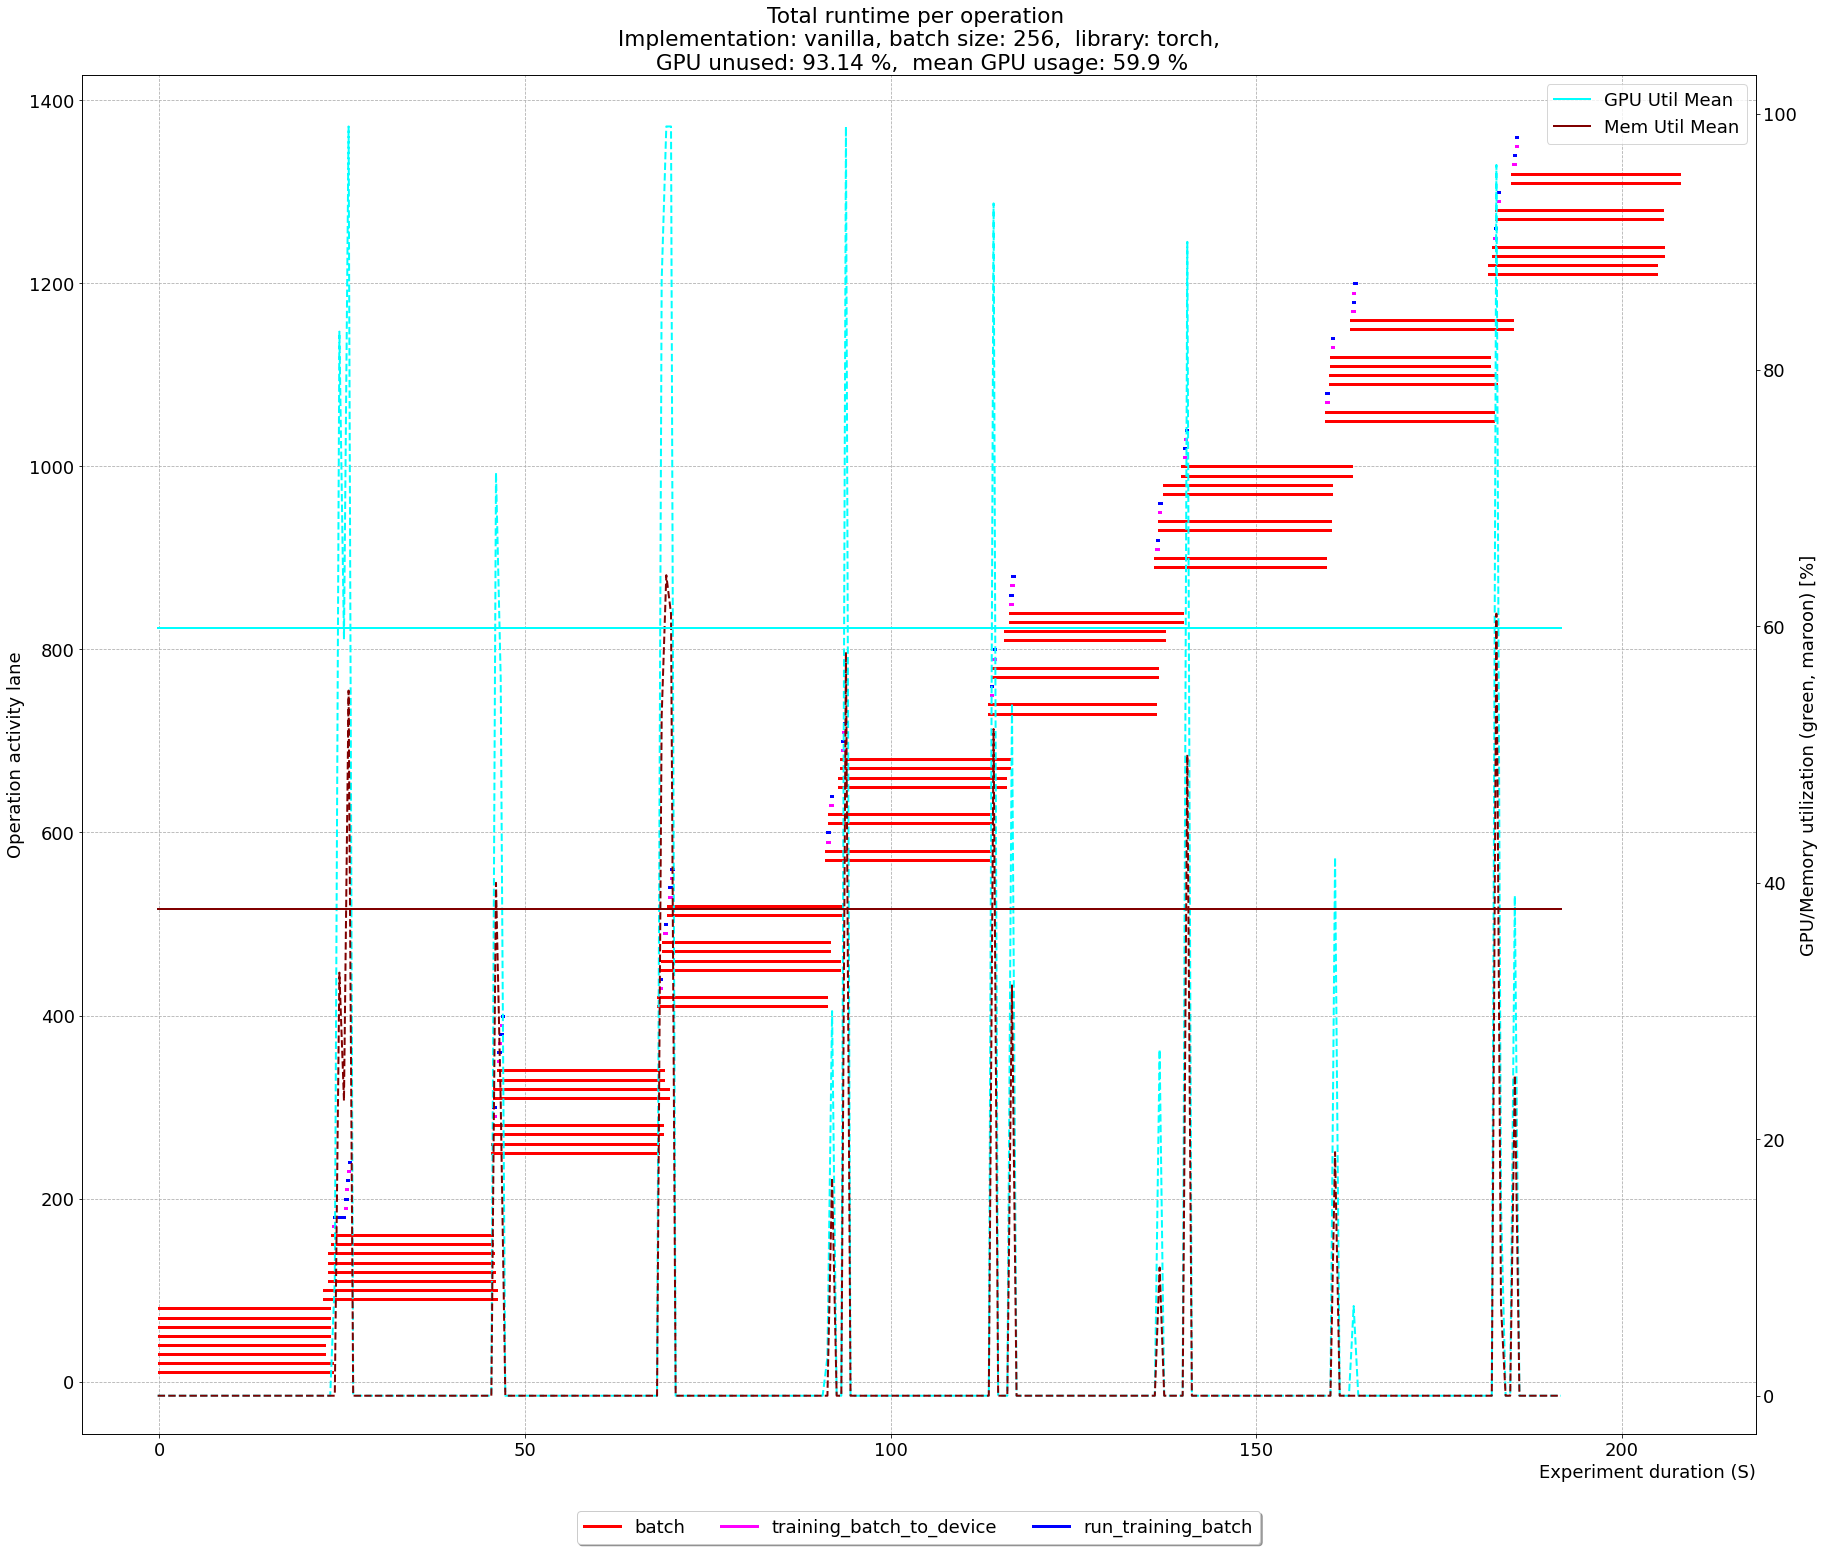

46.25714285714286 23.217391304347824


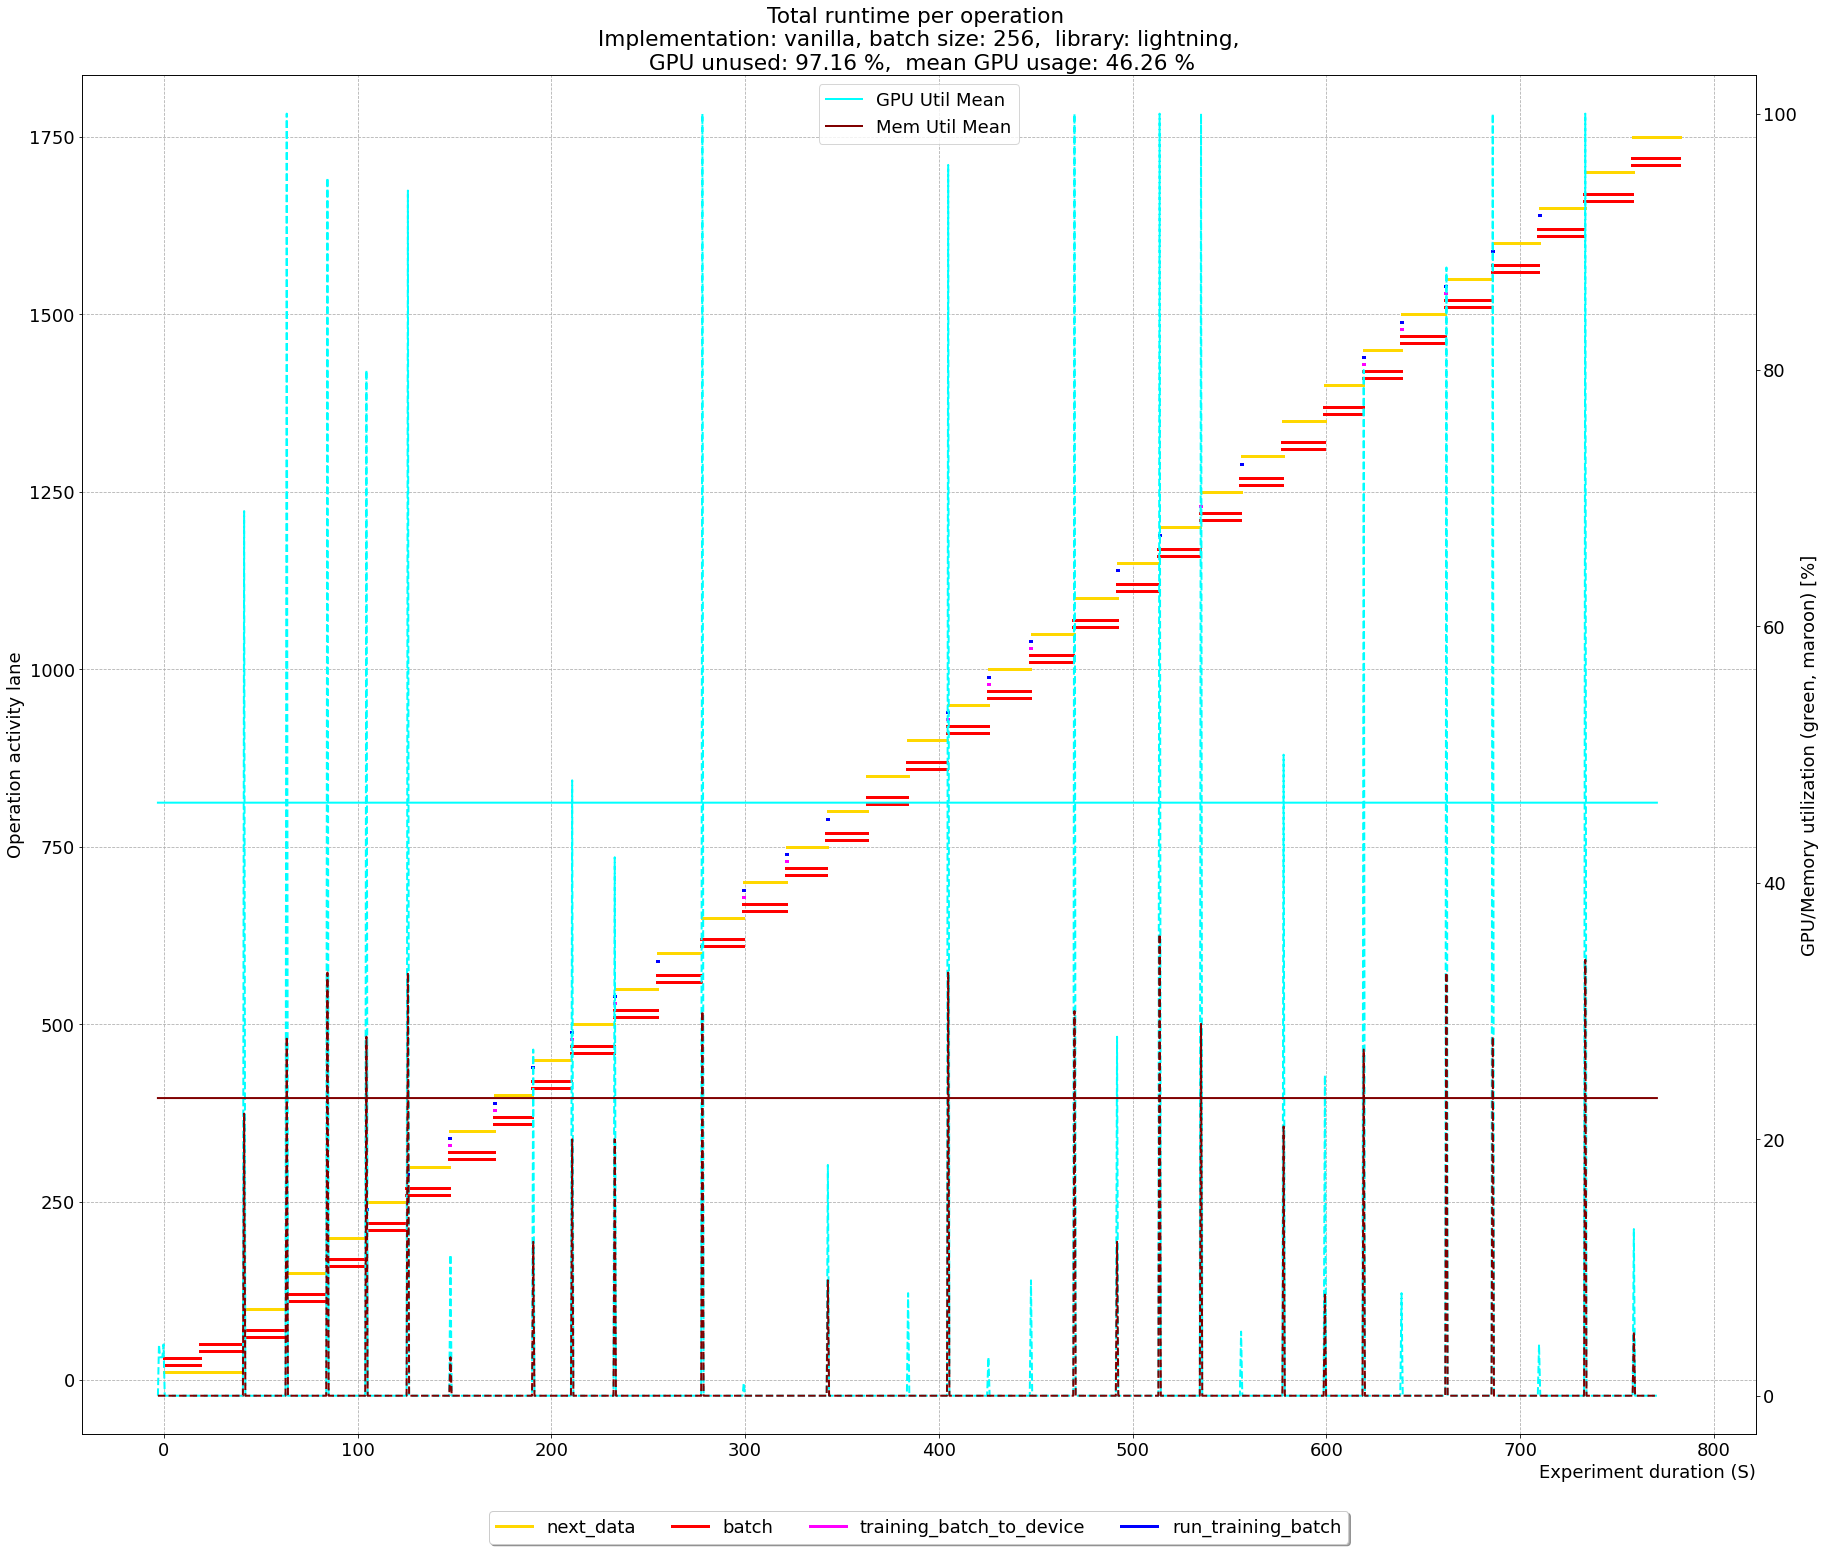

In [9]:
returns_s3 = []
for run in sorted(unique_runs_s3):
    df = df_dataloader_s3[df_dataloader_s3["run"]==run]
    dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
    returns_s3.append(show_timelines_with_gpu(df, dfgpu, lanes, colors, run, False, True, True, 0.05, "0"))
#     break

### Result tables

The following two tables display throughput details for both experiments. The default sample size, i.e. number of dataset items is 3000.

In [20]:
samples = 35000
epochs = 100

In [21]:
# S3
results = pd.DataFrame.from_records(data=returns_s3)
#results["dataset_limit"] / (results["runtime"] / results["epochs"])
results["throughput"] = samples / (results["runtime"] / epochs)
results.sort_values(["runtime", "library"], ascending=True)

,runtime,gpu_util_zero,gpu_util_mean_no_zeros,mem_util_mean,mem_util_mean_no_zeros,implementation,cache,library,throughput
2,15276.229050,73.214286,49.533333,6.678571,31.166667,threaded,0,torch,229.114135
3,15957.507309,57.627119,52.840000,7.542373,26.176471,threaded,0,lightning,219.332502
1,16272.777470,60.000000,41.125000,5.583333,20.937500,asyncio,0,lightning,215.083135
0,16746.884438,74.647887,73.000000,9.788732,46.333333,asyncio,0,torch,208.994098
4,76987.910204,93.137255,59.904762,2.232026,37.944444,vanilla,0,torch,45.461683
5,309552.717990,97.159091,46.257143,0.433442,23.217391,vanilla,0,lightning,11.306636


In [22]:
impls = ["threaded", "asyncio", "vanilla"]
libs = ["torch", "lightning"]

In [23]:
# since the experiment was not repeated, there is not array of values to plot in violin
# so here is a not-so-clever workaround 

df = pd.DataFrame()
def add_stats(row):
    line = [row["throughput"]] * 3
    line.append(0.0)
    line.append(0.0)
    new_row = pd.DataFrame([pd.Series(line)], index = [row["implementation"] + "_" + row["library"]])
    return df.append(new_row)

# add to df
for index, row in results.iterrows():
    df = add_stats(row)

# give names
df.columns = [0, 1, "mean", "std_dev", "var"]

In [24]:
df

,0,1,mean,std_dev,var
asyncio_torch,208.994098,208.994098,208.994098,0.0,0.0
asyncio_lightning,215.083135,215.083135,215.083135,0.0,0.0
threaded_torch,229.114135,229.114135,229.114135,0.0,0.0
threaded_lightning,219.332502,219.332502,219.332502,0.0,0.0
vanilla_torch,45.461683,45.461683,45.461683,0.0,0.0
vanilla_lightning,11.306636,11.306636,11.306636,0.0,0.0


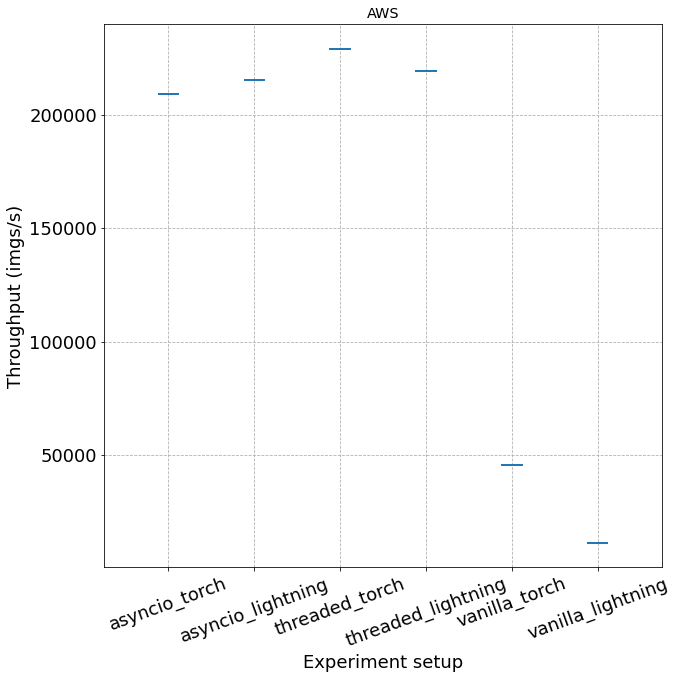

In [15]:
plot_violins(df, "AWS") # 

In [16]:
group_by_dataloader = ["dataset",  "num_fetch_workers", "num_workers"]
df_dataloader = extract_pandas(output_base_folder, folder_filter="*benchmark_e2e*")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2106/2106 [08:03<00:00,  4.35it/s]


In [17]:
df_dataloader_zeroworkers=df_dataloader[df_dataloader["num_workers"]==4]

/iarai/home/ivan.svogor/storage-benchmarking/src/benchmarking/analysis/analyze_results.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_function_name["request_time"] = request_time


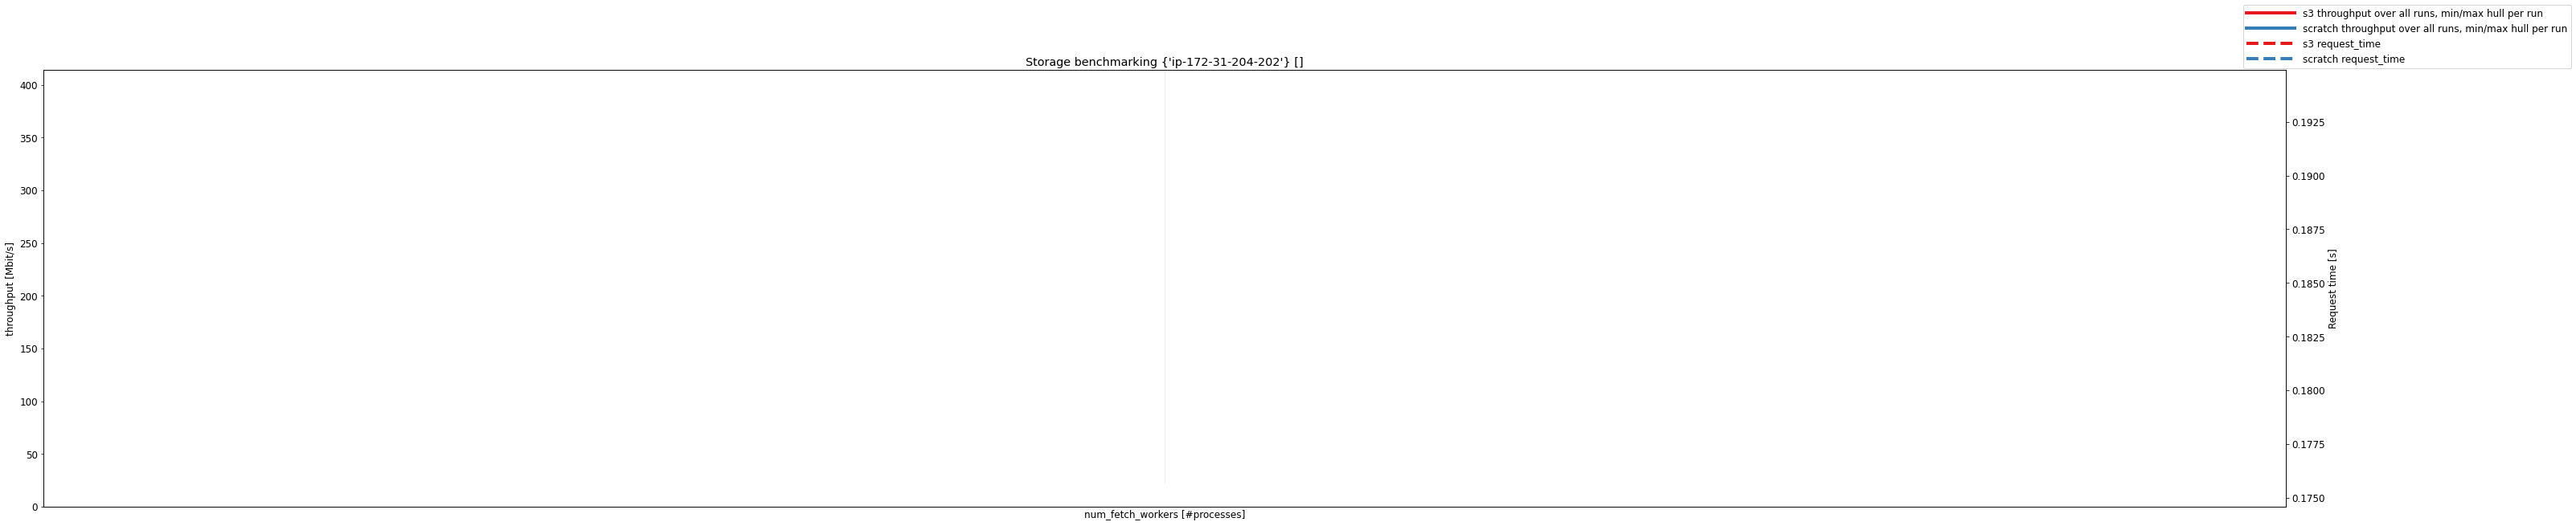

In [18]:
r = plot_throughput_per_storage2(df_dataloader_zeroworkers, group_by_dataloader)

In [19]:
print("throughput [Mbit/s]")

for entry in r:
    for m, value_series in entry.items():
        if type(value_series) is not str:
            for s, m_value in value_series.items():
                print(f"{m} ({s[0]}): {m_value}")

throughput [Mbit/s]
throughput (s3): 82.01883201356543
median_request_time (s3): 0.18474960327148438
